## Conditional workflow which detects the customer review for sentiment analysis and responds based on positive or negative feedback

In [103]:
from typing import TypedDict, Literal
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from pydantic import BaseModel, Field

load_dotenv()

True

In [104]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

## Pydantic to find the sentiment as positive or negative

In [105]:
class Review(BaseModel):
    sentiment: Literal["Positive","Negative"] = Field(description="Review of the product in Positive and Negative")

## Pydantic to find the issue type, tone, urgency

In [106]:
class IssueClassifier(BaseModel):
    issue_type: str = Field(description="Issue type is the issue description")
    tone: Literal["Hard","Mild","Soft"] =  Field(description="Tone is the tone of the review")
    urgency: Literal["High","Medium","Low"] =  Field(description="Urgency categorization")

## For both pydantic class Review and IssueClassifier, defining the structuredoutput

In [107]:
sentiment_model=gpt_llm.with_structured_output(Review)
Issue_classifier=gpt_llm.with_structured_output(IssueClassifier)

In [108]:
class Product(TypedDict):
    product_review: str
    product_sentiment: str
    reply: str
    issue_type: str
    tone: str
    urgency: str

In [109]:
def find_sentiment(state:Product)-> Product:
    product_review=state['product_review']
    prompt=f"Help me find the sentiment of the review given by the customer: \n {product_review}"
    sentiment=sentiment_model.invoke(prompt)
    return {'product_sentiment':sentiment}


In [110]:
def positive_response(state:Product)-> Product:
    product_review=state['product_review']
    product_sentiment=state['product_sentiment']
    prompt=f"Help me reply to the customer based on the product review: \n {product_review} and the sentiment of it \n {product_sentiment}"
    positive_reply=gpt_llm.invoke(prompt)
    return {'reply':positive_reply}




In [111]:
def negative_response(state:Product)-> Product:
    product_review=state['product_review']
    product_sentiment=state['product_sentiment']
    tone=state['tone']
    issue_type=state['issue_type']
    urgency=state['urgency']

    prompt=f"""Help me reply the customer in a very articulated manner based on the negative product review. Carefully device the apology: 
    \n {product_review} and the sentiment of it \n {product_sentiment}. Do consider these factors for a response. \n 
    customer tone: \n {tone} \n 
    Issue type: \n {issue_type} \n
    urgency: \n {urgency} \n"""
    
    negative_reply=gpt_llm.invoke(prompt)
    return {'reply':negative_reply}

In [112]:
def run_dagnosis(state:Product)-> Product:
    product_review=state['product_review']
    prompt=f"With the help of product review try getting classifying the issue with Issue_Type, Tone, Urgency of the issue. Product review as below: \n {product_review}"
    output=Issue_classifier.invoke(prompt)
    return {'issue_type':output.issue_type,'tone':output.tone,'urgency':output.urgency}
    

## Conditional check for positive or negative review - if postive, reply the customer. And if negative run diagnosis

In [113]:
def check_sentiment(state:Product)->  Literal["positive_response","run_dagnosis"]:
    if state["product_sentiment"] == "Positive":
        return "positive_response"
    else:
        return "run_dagnosis"

In [114]:
graph=StateGraph(Product)

In [115]:
graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)
graph.add_node("run_dagnosis",run_dagnosis)

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_dagnosis", "negative_response")
graph.add_edge("negative_response", END)
workflow=graph.compile()


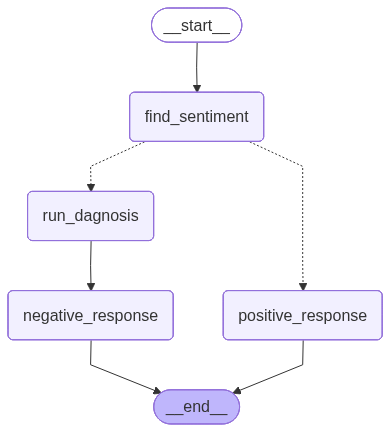

In [116]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [117]:
product_review="The software is killing my productive hours. I need this fixed asap"

In [118]:
workflow.invoke({"product_review":product_review})

{'product_review': 'The software is killing my productive hours. I need this fixed asap',
 'product_sentiment': Review(sentiment='Negative'),
 'reply': AIMessage(content="Subject: We’re Here to Help with Your Software Issue\n\nDear [Customer’s Name],\n\nThank you for taking the time to share your feedback regarding the challenges you’ve been experiencing with our software. I sincerely apologize for the inconvenience you've encountered and understand how critical it is for your productivity.\n\nYour frustration is completely understandable. It is our priority to ensure our software enhances your productivity rather than detracts from it. I want you to know that we are committed to resolving this issue as swiftly as possible.\n\nTo expedite the resolution process, could you please provide any specific details about the software performance issues you're facing? This information will help our technical team diagnose the problem more effectively and implement the necessary fixes.\n\nThank 

In [ ]:
product_review="My graphic card's performance is not up to the mark, but it doesn't cause much of an issue cause I have not been using it"

In [120]:
workflow.invoke({"product_review":product_review})

{'product_review': "My graphic card's performance is not up to the mark, but it doesn't cause much of an issue cause I have not been using it",
 'product_sentiment': Review(sentiment='Negative'),
 'reply': AIMessage(content="Subject: Thank You for Your Feedback\n\nDear [Customer's Name],\n\nThank you for taking the time to share your thoughts regarding your graphic card experience. We strive to ensure our customers have a seamless experience, and I am truly sorry to hear that the performance has not met your expectations.\n\nIt's understandable how disappointing it can be when a product doesn't deliver the expected performance, especially when you haven't had the opportunity to utilize it fully. Your feedback is invaluable in helping us improve our offerings and provide better experiences for all our customers.\n\nIf there's anything specific you'd like to discuss further or if you have any questions regarding the performance, please don't hesitate to reach out. I'm here to assist you 

In [121]:
product_review="The outfit is great and I have been spreading the kind words about all the work you guys do. Just a note to improve on stitching."
workflow.invoke({"product_review":product_review})

{'product_review': 'The outfit is great and I have been spreading the kind words about all the work you guys do. Just a note to improve on stitching.',
 'product_sentiment': Review(sentiment='Positive'),
 'reply': AIMessage(content="Subject: Thank You for Your Feedback!\n\nDear [Customer's Name],\n\nThank you for taking the time to share your thoughts about your recent purchase. We’re thrilled to hear that you love the outfit and appreciate your kind words about our work. Your support means the world to us!\n\nWe also truly value your feedback regarding the stitching quality. While we're pleased to know that you are enjoying the outfit overall, we understand that the finishing details are just as important. We continuously strive to enhance our products, and your insights will help us improve and provide even better quality in the future.\n\nIf you have any further suggestions or specific details about your experience, please feel free to share. Your feedback is instrumental in our pur